# Accessing HSC public DR2 with `unagi`
By [Song Huang](http://dr-guangtou.github.io) and [Jiaxuan Li](https://astrojacobli.github.io).

HSC (Hyper Suprime-Cam) is the state-of-the-art deep sky survey conducted by NAOJ. Now the new public data release (PDR2, https://hsc-release.mtk.nao.ac.jp/doc/) covers 300 square degrees in all five band (`grizy`) with 26.2 mag detection! Everyone could access this wonderful sky survey data for free. If you are a galaxy guy, I'm sure that you'll be amazed by the mind-blowing deep images of your galaxies and find something new that you cannot find in old surveys (such as SDSS). 

Here's some steps you need to follow:
- Register an account in NAOJ server: https://hsc-release.mtk.nao.ac.jp/datasearch/new_user/new. You'll get an long random password for your input username. Please remember to put it down somewhere since the password cannot be changed.

- Assuming you're using macOS/linux. Saving the username and password as environment variables is a good idea. You can open `~/.bash_profile` (or `~/.bashrc`) and write `export SSP_PDR_USR='xxx'`, `export SSP_PDR_PWD='yyy'`. To make them take effect, do `$. ~/.bash_profile` (or `$. ~/.bashrc`). Remember to open another terminal and start your work after this. Note that you can also pass the username and password by giving a `config_file`, which is a simple plain text file containing username and password. You can input username and password manually of course.

- Although you could explore images using [hscMap](https://hsc-release.mtk.nao.ac.jp/hscMap-pdr2/app/), it's hard to download thousands of images by that way. To make things easier, [Song Huang](http://dr-guangtou.github.io) and [Jiaxuan Li](https://astrojacobli.github.io) wrote a package called `unagi` (https://github.com/dr-guangtou/unagi) based on Python3. It's still under construction but it's already good to use. Clone the repo and `python setup.py install`.

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from astropy.table import Table
from astropy.io import fits
#from astropy.utils.data import download_file

import matplotlib.pyplot as plt

from unagi import config, hsc

# What does HSC-SSP DR2 have?


In [11]:
from unagi import config

In [12]:
# You can check available data realses:
config.AVAILABLE_DRS

['pdr1', 'pdr2', 'dr1', 'dr2']

In [4]:
# We setup a configuration for public DR2
pdr2_config = config.Server(dr='pdr2')
# We list available filter list here:
print(pdr2_config.filter_list_short)
# In each DR, there are different layers (such as `wide` or `deep`) of data. 
# Generally 'pdr2_wide' is fine.
print('\n', pdr2_config.rerun_list)
# HSC covers famous sky regions (especially those with dense spectroscopic data).
print('\n', pdr2_config.field_name)

['g', 'r', 'i', 'z', 'y', 'nb387', 'nb816', 'nb921']

 ['any', 'pdr2_dud', 'pdr2_wide', 'pdr2_cosmos_wide_depth_best', 'pdr2_cosmos_wide_depth_median', 'pdr2_cosmos_wide_depth_worst']

 ['DUD_COSMOS', 'DUD_DEEP2-3', 'DUD_ELAIS-N1', 'DUD_XMM-LSS', 'WIDE_WIDE01', 'WIDE_WIDE02', 'WIDE_WIDE03', 'WIDE_WIDE04', 'WIDE_WIDE05', 'WIDE_WIDE06', 'WIDE_WIDE07']


In [13]:
import slug

Other facts:
- Pixel scale: 0.168 arcsec/pixel, smaller than DES (0.272 arcsec/pixel) and SDSS (0.395 arcsec/pixel)
- Zeropoint: 27.0 for `grizy`

# How to use DR2?

In [17]:
# Interesting object list
obj_cat = Table.read('./interesting_obj.txt', format='ascii')
obj_cat[-5:]

index,ra,dec,description
int64,float64,float64,str50
29,150.00240739915483,3.0868122974359844,ETG: minor merger with shell
30,149.99270032766935,3.0421562865727125,Major merger of disk galaxy
31,149.99714346818493,3.0282761024932263,Strong lens or SF ring?
32,149.99430017408494,3.003616062628966,ETG: minor merger with shell
33,150.0801054943501,2.888477112973105,ETG: merger with shell


In [18]:
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout, hsc_tricolor
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord

# Setup HSC server
pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


### Download cutout images

In [19]:
obj = obj_cat[-1]
# Sky coordinate of your object
coord_obj = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

# Retrieving cutout image in filter: i


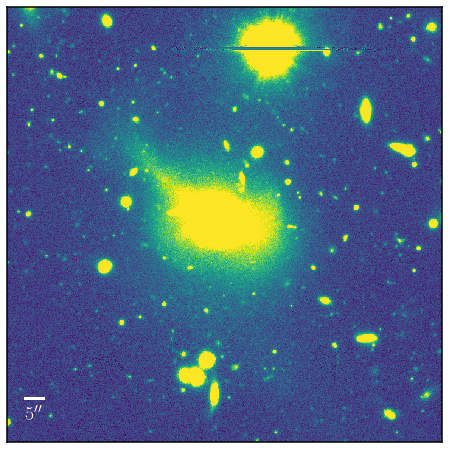

In [20]:
# Angular size (must with unit!)
s_ang = 1 * u.arcmin

cutout = hsc_cutout(coord_obj,
                    cutout_size=s_ang,
                    filters='i',
                    archive=pdr2,
                    use_saved=False,
                    mask=True,
                    variance=True,
                    output_dir='./',
                    verbose=True,
                    save_output=True)
_ = plotting.display_single(cutout[1].data)
cutout.close()

# Retrieving cutout image in filter: i


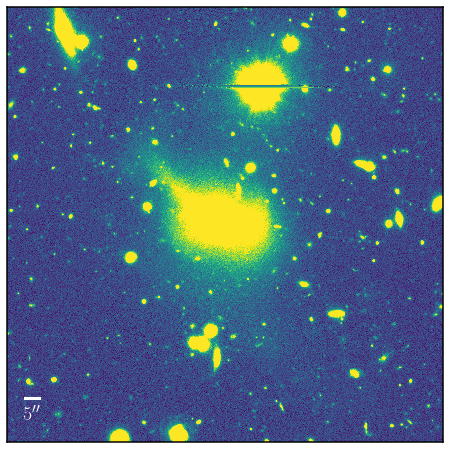

In [23]:
# Physical size
s_phys = 200.0 * u.kpc
redshift = 0.15

cutout = hsc_cutout(coord_obj,
                    cutout_size=s_phys,
                    redshift=redshift,
                    filters='i',
                    archive=pdr2,
                    use_saved=False,
                    mask=False,
                    variance=True,
                    output_dir='./',
                    verbose=True,
                    save_output=True)
_ = plotting.display_single(cutout[1].data)
cutout.close()

The returned `cutout` has four layers. Zeroth layer is always empty, first layer is image, second and third is HSC binary mask and variance, respectively.

If `mask=False`, then `cutout[2]` is null.

We can also download multi-band images simultaneously.

In [28]:
cutout_multi = hsc_cutout(coord_obj,
                    cutout_size=s_ang,
                    filters='gri',
                    archive=pdr2,
                    use_saved=False,
                    mask=True,
                    variance=True,
                    output_dir='./',
                    verbose=True,
                    save_output=True)

# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


In [32]:
cutout_g, cutout_r, cutout_i = cutout_multi

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x13332b438>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133359a20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133345fd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133d3af60>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x133d39160>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133d3d7f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133d41c88>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133d47ba8>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x133d4b550>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133d4bcc0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x133d53898>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1335937b8>]]

### Download tri-color images

In [28]:
# Use physical size and saved the data
cutout_rgb, cutout_wcs = hsc_tricolor(
    coord_obj,
    cutout_size=s_phys,
    redshift=redshift,
    filters='gri',
    verbose=True,
    save_rgb=True,
    save_img=True,
    use_saved=True,
    output_dir='./',
    archive=pdr2)


# RGB picture will be saved as ./pdr2_wide_150.0801_2.8885_200.00kpc_gri.jpg
# Read in saved FITS file: True
# Read in saved FITS file: True
# Read in saved FITS file: True


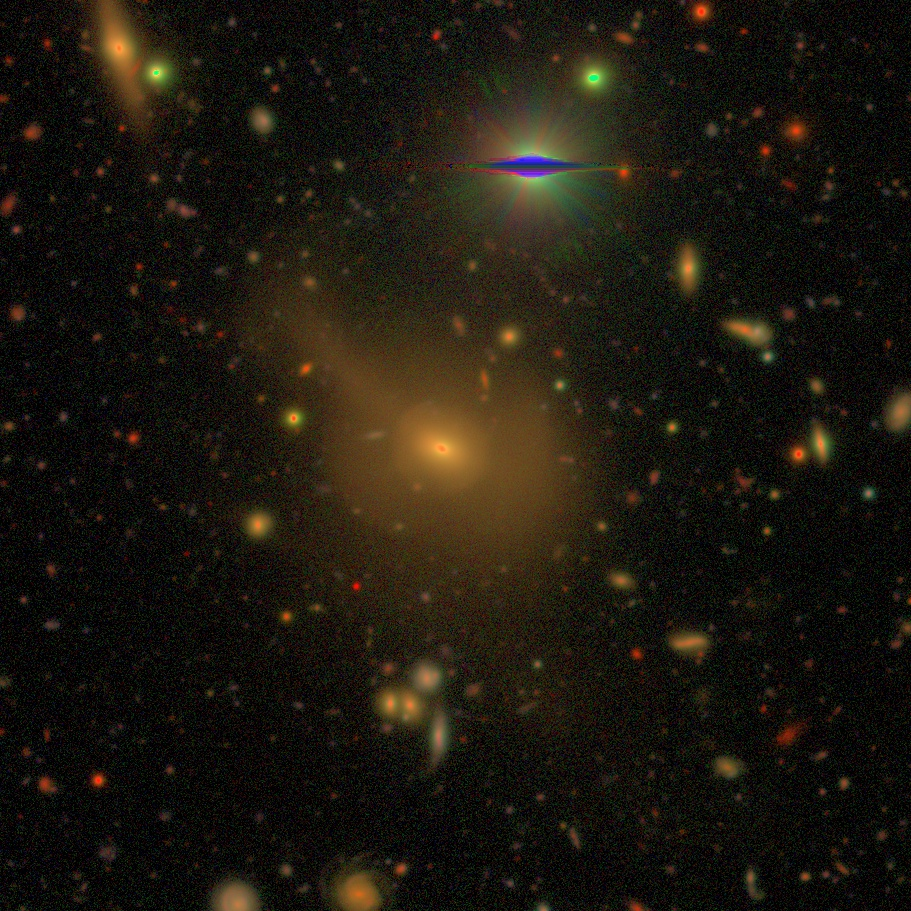

In [29]:
Image('./pdr2_wide_150.0801_2.8885_200.00kpc_gri.jpg', width=500, height=500)

In [71]:
# Diagonal cutout of large sky region
coord_1 = SkyCoord(339.086854, 1.8399, frame='icrs', unit='deg')
coord_2 = SkyCoord(338.780632, 1.5499, frame='icrs', unit='deg')

cutout_rgb, cutout_wcs = hsc_tricolor(
    coord_1, coord_2=coord_2, filters='gri', verbose=True, 
    save_rgb=True, save_img=True, use_saved=True, archive=pdr2,
    rgb_stretch=0.2)

# RGB picture will be saved as ./pdr2_wide_ra_339.0869_1.8399_dec_339.0869_1.8399_gri.jpg
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


### Masks

In [31]:
from unagi import mask
# BitMasks class holds information about the mask planes for a given dataset. 
pdr2_mask = mask.BitMasks(data_release='pdr2')

pdr2_mask.show_table()

idx,bits,name,meaning,color,value
0,0,BAD,Bad pixel,red,1
1,1,SAT,Source footprint includes saturated pixels,tab:purple,2
2,2,INTRP,Source footprint includes interpolated pixels,tab:orange,4
3,3,CR,Source footprint includes suspected CR pixels,tab:pink,8
4,4,EDGE,Source is close to the edge of the CCD,tab:olive,16
5,5,DETECTED,Pixel with detection above the threshold,tab:blue,32
6,6,DETECTED_NEGATIVE,Pixel in footprint that is detected as a negative object,gray,64
7,7,SUSPECT,Source footprint includes suspect pixels,orangered,128
8,8,NO_DATA,No useful data,black,256
9,9,BRIGHT_OBJECT,Bright star mask,tab:brown,512


In [32]:
cutout = hsc_cutout(coord_obj,
                    cutout_size=s_phys,
                    redshift=redshift,
                    filters='i',
                    archive=pdr2,
                    use_saved=False,
                    mask=True,
                    variance=True,
                    output_dir='./',
                    verbose=True,
                    save_output=True)
w = wcs.WCS(cutout[1].header)
bitmask = cutout[2].data
bit_mask = mask.Mask(bitmask, data_release='pdr2')

# Retrieving cutout image in filter: i


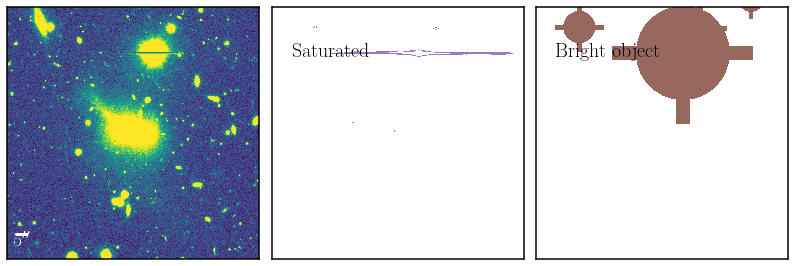

In [118]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
plotting.display_single(cutout[1].data, ax=ax[0])
bit_mask.display('SAT', ax=ax[1], add_text='Saturated', text_color='k', text_fontsize=20)
bit_mask.display('BRIGHT_OBJECT', ax=ax[2], add_text='Bright\ object', text_color='k', text_fontsize=20)
plt.subplots_adjust(wspace=0.05)

# Detect 345 objects
The number of bright objects:  3


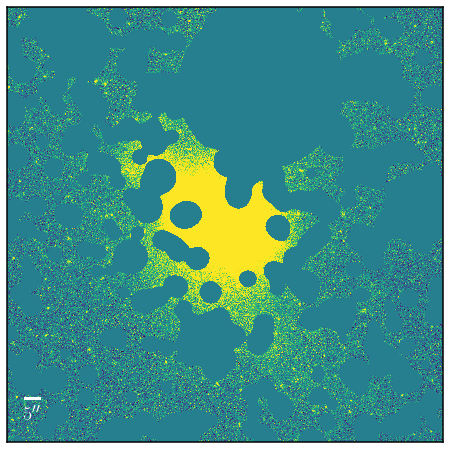

In [113]:
import slug
from slug import imutils, profile
import warnings
warnings.simplefilter('ignore')

# extract_obj.
data = cutout[1].data
data = data.byteswap().newbyteorder()
objects, segmap = profile.extract_obj(
    data,
    b=30,
    f=5,
    sigma=3.0,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.001,
    deblend_nthresh=20,
    show_fig=False)
# Mask HSC bright object mask
hsc_mask = imutils.make_HSC_bright_obj_mask(cutout[2].data, objects, segmap)
seg_mask = imutils.make_binary_mask(data, cutout_wcs, segmap, radius=10, threshold=0.01,
                                    gaia=True, factor_b=1.2, 
                                    sep_objcat=objects, sep_zp = slug.HSC_zeropoint,
                                    sep_mag=18.0, sep_blowup=7, 
                                    show_fig=False)
tot_mask = seg_mask + hsc_mask
# Show masked image
plotting.display_single(data*(~tot_mask));

### Filter

In [121]:
from unagi import filters
from unagi import camera

In [125]:
hsc_cam = camera.Camera()
# Total transmission curves
hsc_filter_total = filters.hsc_filters(use_saved=False)

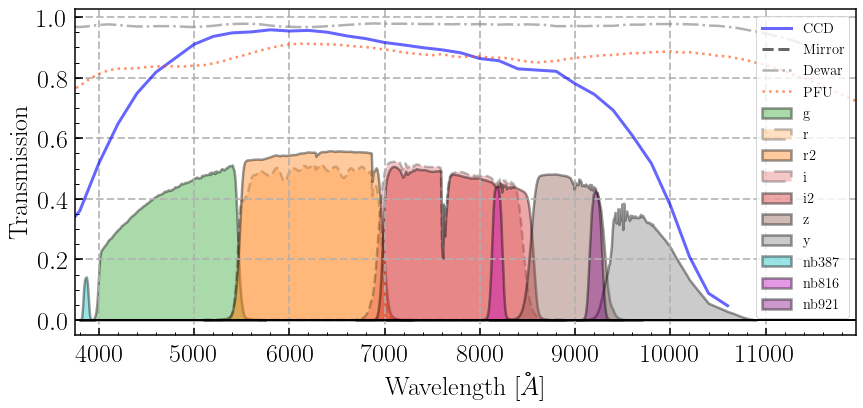

In [126]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.8)

# Show the CCD QE
ax1.plot(hsc_cam.qe[:, 0], hsc_cam.qe[:, 1], linewidth=3.0, alpha=0.6, color='b',
         label=r'$\rm CCD$')

# Show the primary mirror reflectivity
ax1.plot(hsc_cam.primary_reflect[:, 0], hsc_cam.primary_reflect[:, 1], 
         linewidth=3.0, alpha=0.6, color='k', linestyle='--',
         label=r'$\rm Mirror$')

# Show the transparency of the dewar window
ax1.plot(hsc_cam.dewar[:, 0], hsc_cam.dewar[:, 1], 
         linewidth=2.5, alpha=0.6, color='gray', linestyle='-.',
         label=r'$\rm Dewar$')

# Show the transparency of the PFU: prime focus unit
ax1.plot(hsc_cam.popt2[:, 0], hsc_cam.popt2[:, 1], 
         linewidth=2.5, alpha=0.6, color='orangered', linestyle=':',
         label=r'$\rm PFU$')

# Overplot all the filters
for filt in hsc_filter_total:
    if filt['short'] == 'r' or filt['short'] == 'i':
        linestyle, alpha = '--', 0.25
    else:
        linestyle, alpha = '-', 0.4
    
    ax1.axhline(0.0, linewidth=2, color='k', alpha=0.8)
    # Filled the transmission curve
    ax1.fill_between(filt['wave'], 0.0, filt['trans'], edgecolor='k', 
                     alpha=alpha, linewidth=2.5, linestyle=linestyle,
                     facecolor=filt['color'], 
                     label=r'$\rm {0}$'.format(filt['short'])) 

ax1.legend(loc='best', fontsize=14.5)

_ = ax1.set_xlim(3750, 11950)
_ = ax1.set_xlabel(r'$\mathrm{Wavelength}\ [\AA]$')
_ = ax1.set_ylabel(r'$\mathrm{Transmission}$')
